# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


In [2]:
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

2025-06-28 07:16:12.418124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751094972.619022      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751094972.685954      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploratory Data Analysis

In [3]:
len(os.listdir(r"/kaggle/input/leafdata")) #Add augmented train folder here

1

# Data PreProcessing

## Using MobileNet-V3

In [4]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions

# Data generators
train_datagen = ImageDataGenerator(zoom_range=0.5, 
                                   shear_range=0.3,  
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
train = train_datagen.flow_from_directory(directory=r"/kaggle/input/leafdata/data_split/train",
                                          target_size=(256,256),
                                          batch_size=32,
                                          class_mode='sparse'
                                          )

val = val_datagen.flow_from_directory(directory=r"/kaggle/input/leafdata/data_split/val",
                                      target_size=(256,256),
                                      batch_size=32,
                                      shuffle=False,
                                      class_mode='sparse')

Found 83629 images belonging to 71 classes.
Found 22131 images belonging to 71 classes.


In [6]:
t_img, label = next(train)

In [7]:
t_img.shape

(32, 256, 256, 3)

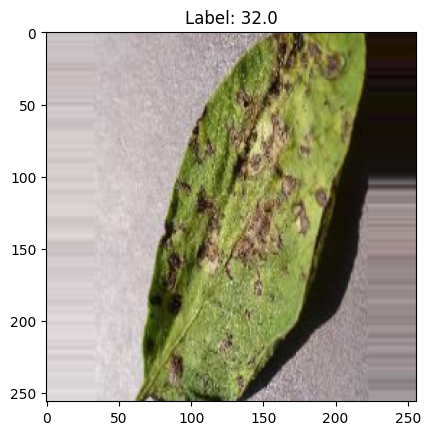

In [8]:
# Reverse the preprocessing to display the image correctly
t_img_display = t_img[0].copy()
t_img_display = t_img_display - np.min(t_img_display)
t_img_display = t_img_display / np.max(t_img_display)

# Display the first image and its label
plt.imshow(t_img_display)
plt.title(f'Label: {label[0]}')
plt.show()

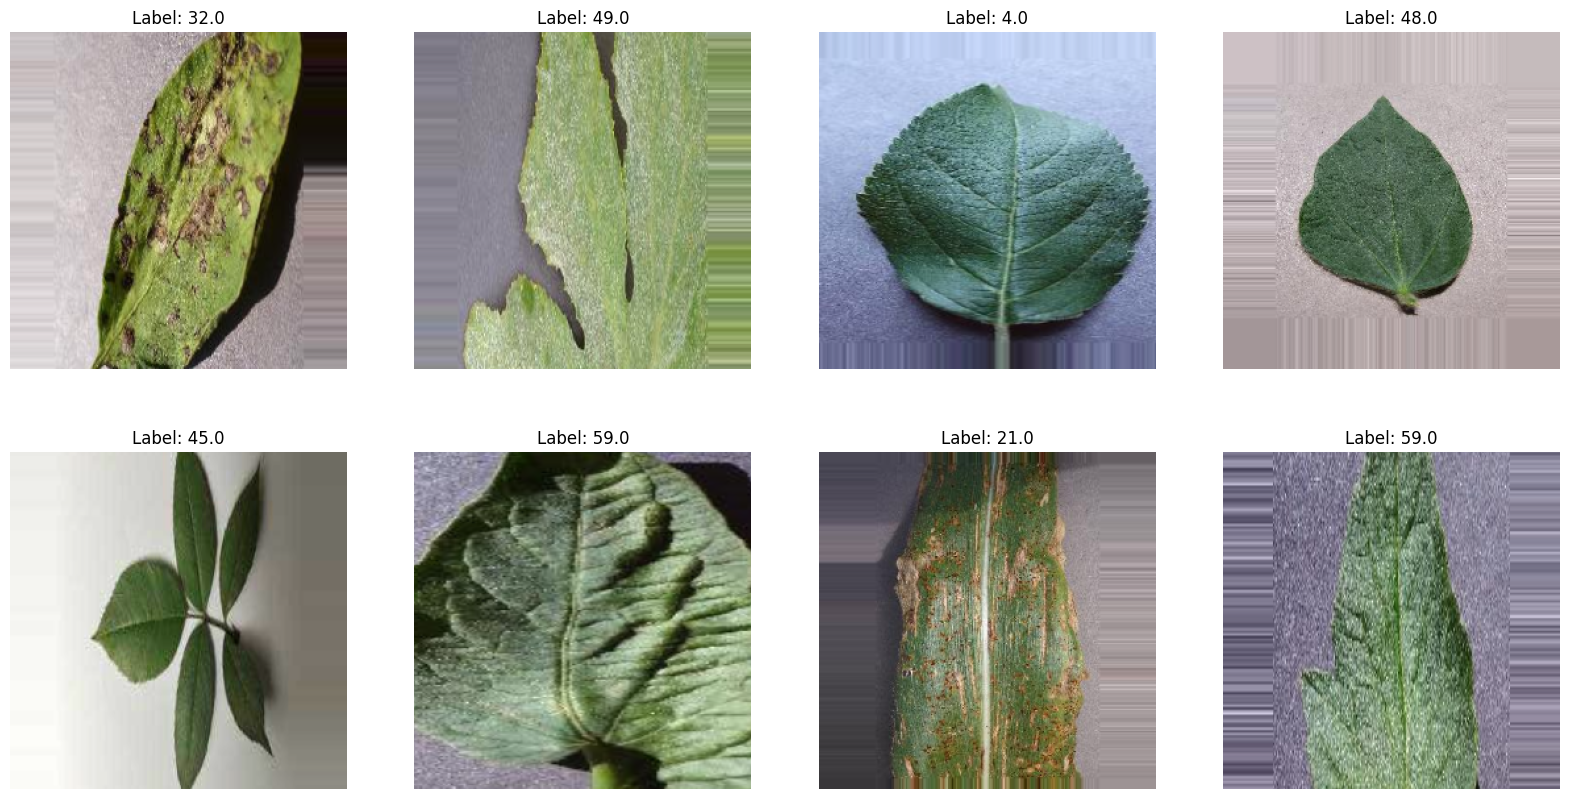

In [9]:
# Reverse the preprocessing to display the images correctly
def reverse_preprocessing(img):
    img = img.copy()
    img = img - np.min(img)
    img = img / np.max(img)
    return img

num_images = 8
plt.figure(figsize=(20, 10))
for i in range(num_images):
    img = reverse_preprocessing(t_img[i])
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f'Label: {label[i]}')
    plt.axis('off')
plt.show()

# Building the Model

In [10]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Small
import keras


In [11]:
import os
print(os.listdir())  # Should show the weights file


['.virtual_documents']


In [12]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

def build_leaf_model(input_shape=(256,256,3), dropout_rate=0.3):
    base_model = MobileNetV3Small(input_shape=input_shape, include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(71, activation='softmax', dtype ='float32')(x)
    model = Model(base_model.input, output)
    return base_model, model

base_basic, basic_model = build_leaf_model()
for layer in base_basic.layers:
    layer.trainable = False
base_model1, model_1 = build_leaf_model()
for layer in base_model1.layers:
    layer.trainable = False
base_model2, model_2 = build_leaf_model()
for layer in base_model2.layers[:-20]:  # Unfreeze last 20 layers only
    layer.trainable = False

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
I0000 00:00:1751095015.588750      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751095015.589488      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
base_model1.summary()

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_2 (Cast)             │ (None, 256, 256, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ cast_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 128, 128, 16)   │            432 │ rescaling_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 128, 128, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 128, 128, 16)   │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 129, 129, 16)   │              0 │ activation_18[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_14 (ReLU)           │ (None, 64, 64, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu_14[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)          

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

In [14]:
# Basic-Model

basic_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [15]:
!pip install focal-loss


In [16]:
# Model - 1
from focal_loss import SparseCategoricalFocalLoss

model_1.compile(
    optimizer='adam',
    loss=SparseCategoricalFocalLoss(gamma=2.0),
    metrics=['accuracy']
)

In [17]:
# model - 2
model_2.compile(
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5),
    loss=SparseCategoricalFocalLoss(gamma=2.0),
    metrics=['accuracy']
)

# Early Stopping & model Checkpoint

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
mc_basic = ModelCheckpoint("best_model.keras",
                           monitor='val_accuracy',
                           save_best_only=True)
mc_model1 = ModelCheckpoint("best_model_1.keras", 
                            monitor='val_accuracy',
                            save_best_only=True)
mc_model2 = ModelCheckpoint("best_model_2.keras",
                            monitor='val_accuracy',
                            save_best_only=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)



In [19]:
# Fine tuning which takes ample of time to run but will give good results
his_basic = basic_model.fit(train, 
                steps_per_epoch=16,
                epochs=50,
                verbose=1,
                callbacks=[es,mc_basic,rlr],
                validation_data=val,
                validation_steps=16)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1751095032.915404     116 service.cc:148] XLA service 0x7e73b000ae00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751095032.916206     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751095032.916227     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751095033.987598     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4:04 16s/step - accuracy: 0.0000e+00 - loss: 4.9486

I0000 00:00:1751095040.906097     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.0328 - loss: 4.5195 - val_accuracy: 0.0000e+00 - val_loss: 5.0318 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 558ms/step - accuracy: 0.1714 - loss: 3.6705 - val_accuracy: 0.0000e+00 - val_loss: 4.8418 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 600ms/step - accuracy: 0.2418 - loss: 3.3509 - val_accuracy: 0.0410 - val_loss: 4.2844 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 597ms/step - accuracy: 0.2945 - loss: 3.0277 - val_accuracy: 0.0684 - val_loss: 4.2358 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 562ms/step - accuracy: 0.3291 - loss: 2.7809 - val_accuracy: 0.1133 - val_loss: 4.0402 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 525ms/step - accuracy: 0.4011 - loss: 2.5141 - val_accuracy: 0.0234 - val_loss: 4.0901 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 551ms/step - accuracy: 0.4313 - loss: 2.4133 - val_a

In [20]:

his_model1 = model_1.fit(
    train,
    steps_per_epoch=16,
    epochs=50,
    validation_data=val,
    validation_steps=16,
    callbacks=[es,mc_model1,rlr]  
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 953ms/step - accuracy: 0.0359 - loss: 4.5217 - val_accuracy: 0.0000e+00 - val_loss: 4.8135 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 554ms/step - accuracy: 0.1339 - loss: 3.5073 - val_accuracy: 0.0000e+00 - val_loss: 4.9503 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 590ms/step - accuracy: 0.2339 - loss: 3.1226 - val_accuracy: 0.0078 - val_loss: 4.9619 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 564ms/step - accuracy: 0.2527 - loss: 2.8518 - val_accuracy: 0.0176 - val_loss: 4.8698 - learning_rate: 2.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 568ms/step - accuracy: 0.3139 - loss: 2.6797 - val_accuracy: 0.0352 - val_loss: 4.7074 - learning_rate: 2.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 541ms/step - accuracy: 0.2880 - loss: 2.6198 - val_accuracy: 0.0391 - val_loss: 4.5716 - learning_rate: 2.0000e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 571ms/step - accuracy: 0.3

In [21]:
his_model2 = model_2.fit(train,
                         steps_per_epoch=len(train),
                         epochs=15,
                         validation_data=val,
                         validation_steps=len(val),
                         callbacks=[mc_model2])

Epoch 1/15
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 1441s 544ms/step - accuracy: 0.1474 - loss: 3.6437 - val_accuracy: 0.4657 - val_loss: 1.9399
Epoch 2/15
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 1252s 479ms/step - accuracy: 0.4308 - loss: 2.0001 - val_accuracy: 0.6425 - val_loss: 1.1387
Epoch 3/15
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 1277s 488ms/step - accuracy: 0.5619 - loss: 1.3480 - val_accuracy: 0.7388 - val_loss: 0.7333
Epoch 4/15
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 1274s 487ms/step - accuracy: 0.6424 - loss: 0.9602 - val_accuracy: 0.7914 - val_loss: 0.5202
Epoch 5/15
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 1266s 484ms/step - accuracy: 0.6898 - loss: 0.7563 - val_accuracy: 0.8178 - val_loss: 0.4010
Epoch 6/15
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 1271s 486ms/step - accuracy: 0.7224 - loss: 0.6302 - val_accuracy: 0.8372 - val_loss: 0.3330
Epoch 7/15
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 1271s 486ms/step - accuracy: 0.7462 - loss: 0.5460 - val_accuracy: 0.8520 - val_loss: 0.2898
Epoch 8/15
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 1270s 486ms/s

In [22]:
h_bas = his_basic.history
h1 = his_model1.history
h2 = his_model2.history

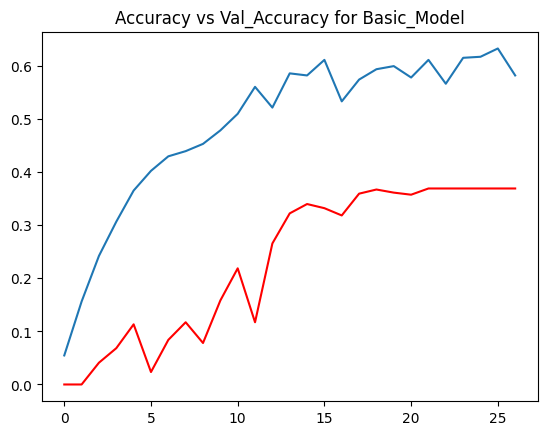

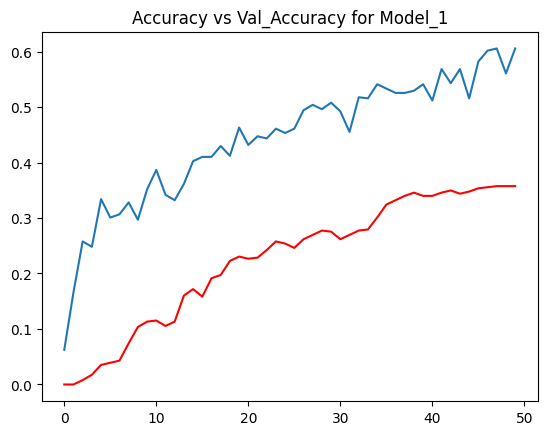

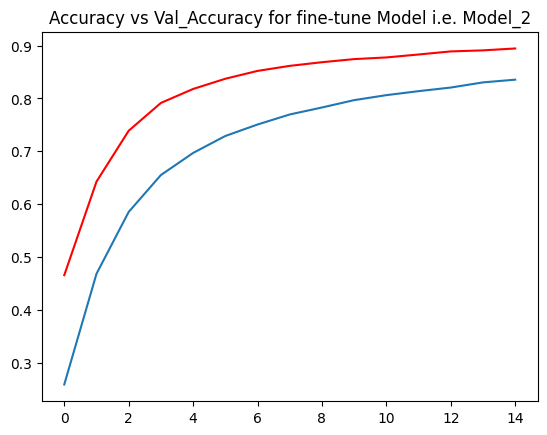

In [23]:
plt.plot(h_bas['accuracy'])
plt.plot(h_bas['val_accuracy'], c="red")
plt.title('Accuracy vs Val_Accuracy for Basic_Model')
plt.show()

plt.plot(h1['accuracy'])
plt.plot(h1['val_accuracy'], c="red")
plt.title('Accuracy vs Val_Accuracy for Model_1')
plt.show()


plt.plot(h2['accuracy'])
plt.plot(h2['val_accuracy'], c="red")
plt.title('Accuracy vs Val_Accuracy for fine-tune Model i.e. Model_2')
plt.show()

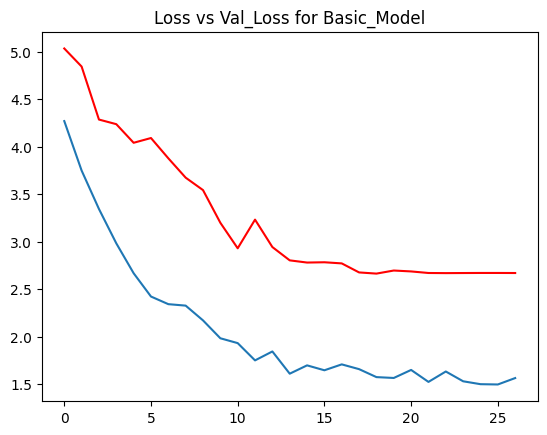

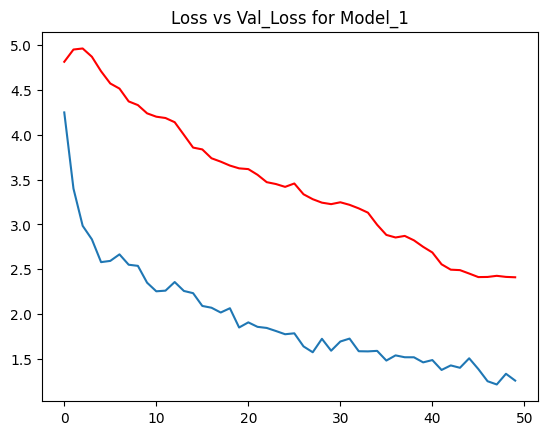

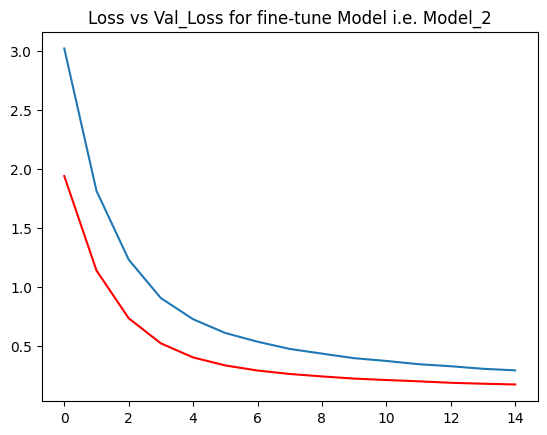

In [24]:
plt.plot(h_bas['loss'])
plt.plot(h_bas['val_loss'], c="red")
plt.title('Loss vs Val_Loss for Basic_Model')
plt.show()

plt.plot(h1['loss'])
plt.plot(h1['val_loss'], c="red")
plt.title('Loss vs Val_Loss for Model_1')
plt.show()

plt.plot(h2['loss'])
plt.plot(h2['val_loss'], c="red")
plt.title('Loss vs Val_Loss for fine-tune Model i.e. Model_2')
plt.show()

In [25]:
from keras.models import load_model
basic_model_best = load_model(r"best_model.keras")
model_1_best = load_model("best_model_1.keras", 
                          custom_objects={'SparseCategoricalFocalLoss': SparseCategoricalFocalLoss(gamma=2.0)})
model_2_best = load_model("best_model_2.keras",
                          custom_objects={'SparseCategoricalFocalLoss': SparseCategoricalFocalLoss(gamma=2.0)})

In [26]:
val_acc_basic = basic_model_best.evaluate(val)[1]
val_acc_model1 = model_1_best.evaluate(val)[1]
val_acc_model2 = model_2_best.evaluate(val)[1]
print(f"Validation Accuracy (Basic Model): {val_acc_basic*100:.2f}%")
print(f"Validation Accuracy (Focal Loss[Model-1]): {val_acc_model1*100:.2f}%")
print(f"Validation Accuracy (Fine-tuned[Model-2]): {val_acc_model2*100:.2f}%")

692/692 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.5831 - loss: 1.6077
692/692 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.5705 - loss: 1.3020
692/692 ━━━━━━━━━━━━━━━━━━━━ 56s 70ms/step - accuracy: 0.8508 - loss: 0.2428
Validation Accuracy (Basic Model): 68.51%
Validation Accuracy (Focal Loss[Model-1]): 67.79%
Validation Accuracy (Fine-tuned[Model-2]): 89.44%


# Confusion Matrix

In [27]:
import tensorflow as tf  
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def generate_confusion_matrix(model, generator):
    generator.reset()
    y_true = generator.classes
    y_pred = model.predict(generator, steps=len(generator))
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    class_names = list(generator.class_indices.keys())
    
    # Visualize (adjust for 71 classes)
    plt.figure(figsize=(25, 20))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',  # Removed annotations for readability
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Classification report
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

692/692 ━━━━━━━━━━━━━━━━━━━━ 50s 66ms/step


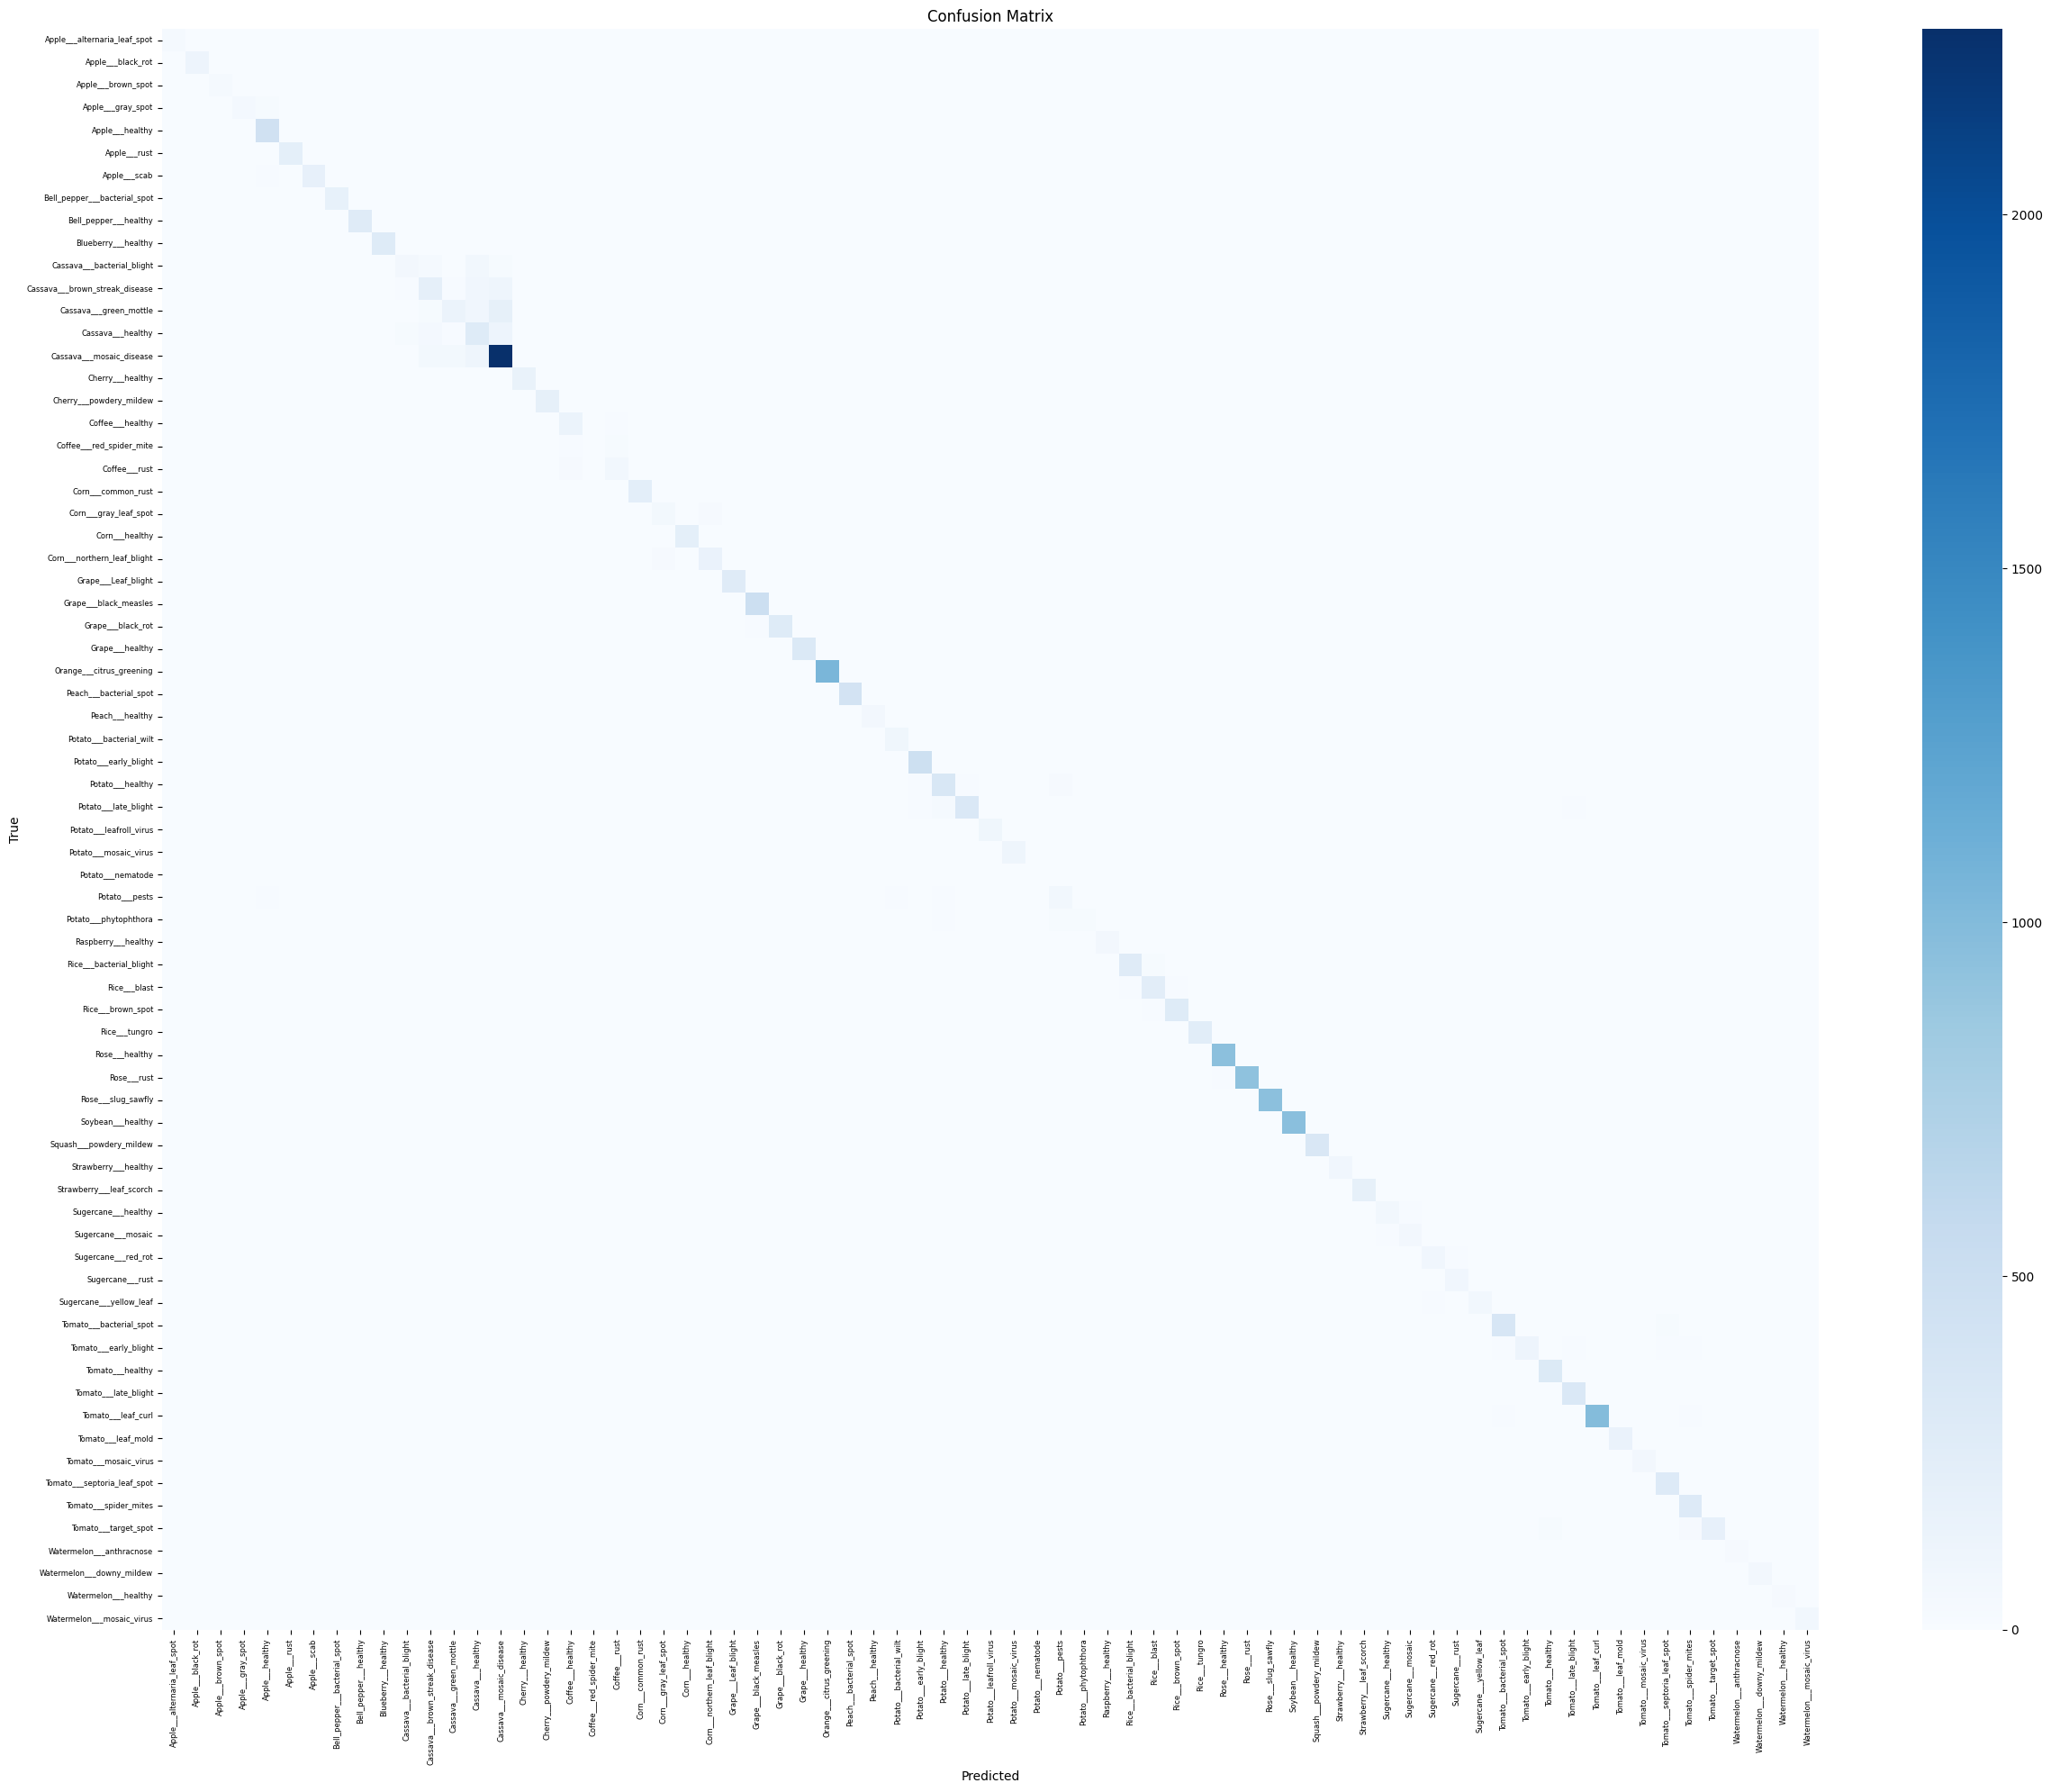

                                precision    recall  f1-score   support

  Apple___alternaria_leaf_spot       0.88      0.80      0.83        54
             Apple___black_rot       0.91      0.97      0.94       119
            Apple___brown_spot       0.93      0.95      0.94        41
             Apple___gray_spot       0.98      0.62      0.76        76
               Apple___healthy       0.87      0.94      0.90       489
                  Apple___rust       0.91      0.90      0.90       237
                  Apple___scab       0.91      0.83      0.87       233
  Bell_pepper___bacterial_spot       0.92      0.97      0.95       190
         Bell_pepper___healthy       0.95      0.99      0.97       282
           Blueberry___healthy       0.95      1.00      0.98       286
    Cassava___bacterial_blight       0.57      0.33      0.41       208
Cassava___brown_streak_disease       0.55      0.49      0.52       417
        Cassava___green_mottle       0.61      0.30      0.41  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
generate_confusion_matrix(model_2_best, val)

# Testing with new Image

In [37]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import random
# Define your test directory
test_dir = r"/kaggle/input/leafdata/data_split/test"

def random_image_predict(model, model_name, test_dir, num_images=5):
    # Build class mapping from sorted folder names for consistency
    class_folders = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
    idx_to_class = {i: class_name for i, class_name in enumerate(class_folders)}
    
    # Gather all image paths and their true classes
    all_images = []
    for class_name in class_folders:
        class_dir = os.path.join(test_dir, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_images.append((os.path.join(class_dir, img_name), class_name))
    
    # Randomly select images
    selected_images = random.sample(all_images, min(num_images, len(all_images)))
    
    # Predict and display
    for img_path, true_class in selected_images:
        img = load_img(img_path, target_size=(256, 256))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)
        
        pred = model.predict(img_array, verbose=0)
        pred_idx = np.argmax(pred)
        pred_class = idx_to_class[pred_idx]
        
        plt.imshow(img)
        plt.title(f"Model: {model_name}\nTrue: {true_class}\nPredicted: {pred_class}")
        plt.axis('off')
        plt.show()
        
        print(f"Model: {model_name}")
        print(f"Image: {os.path.basename(img_path)}")
        print(f"True class: {true_class}")
        print(f"Predicted class: {pred_class}")
        print("-" * 50)


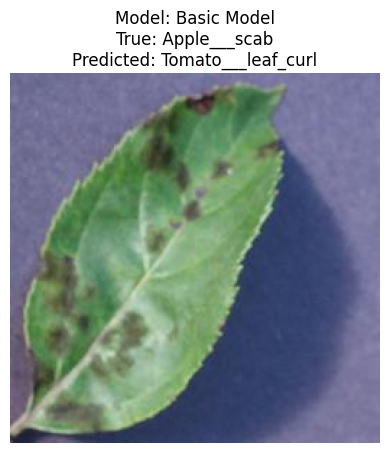

Model: Basic Model
Image: 42823.jpg
True class: Apple___scab
Predicted class: Tomato___leaf_curl
--------------------------------------------------


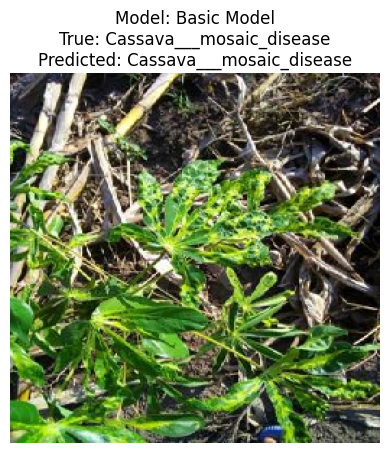

Model: Basic Model
Image: 31567.jpg
True class: Cassava___mosaic_disease
Predicted class: Cassava___mosaic_disease
--------------------------------------------------


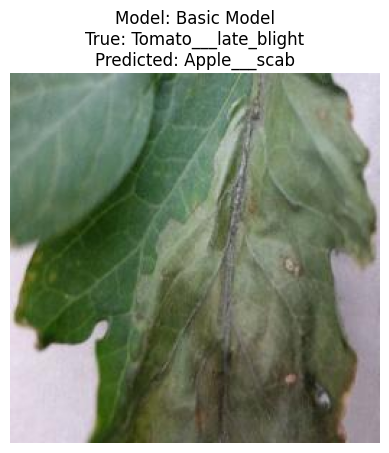

Model: Basic Model
Image: 82414.jpg
True class: Tomato___late_blight
Predicted class: Apple___scab
--------------------------------------------------


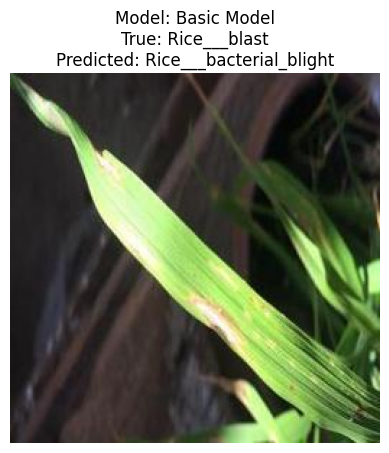

Model: Basic Model
Image: 38310.jpg
True class: Rice___blast
Predicted class: Rice___bacterial_blight
--------------------------------------------------


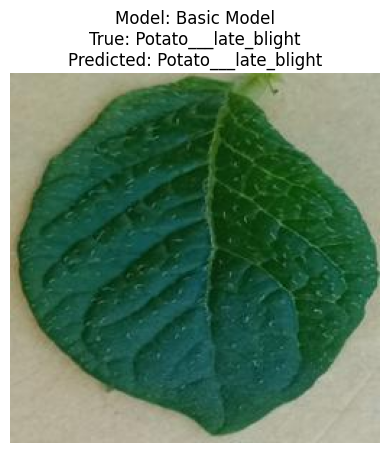

Model: Basic Model
Image: 98801.jpg
True class: Potato___late_blight
Predicted class: Potato___late_blight
--------------------------------------------------


In [41]:
# Example usage for any loaded model:
random_image_predict(basic_model_best, "Basic Model", test_dir)

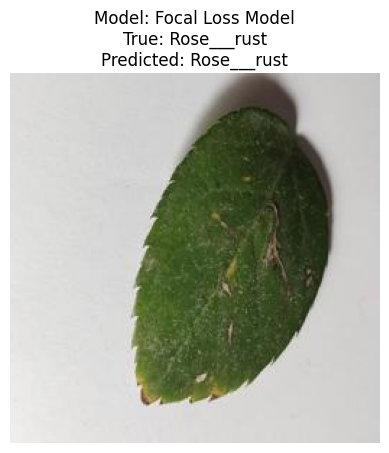

Model: Focal Loss Model
Image: 7803.jpg
True class: Rose___rust
Predicted class: Rose___rust
--------------------------------------------------


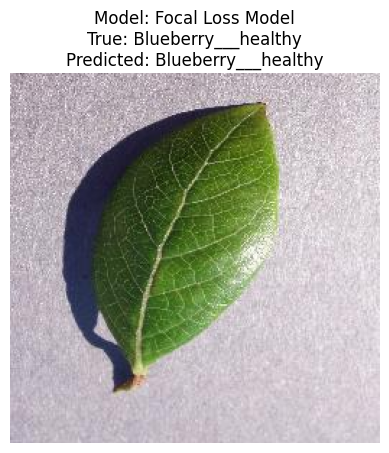

Model: Focal Loss Model
Image: 46313.jpg
True class: Blueberry___healthy
Predicted class: Blueberry___healthy
--------------------------------------------------


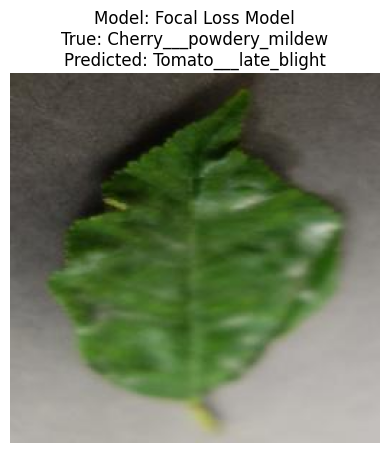

Model: Focal Loss Model
Image: 47832.jpg
True class: Cherry___powdery_mildew
Predicted class: Tomato___late_blight
--------------------------------------------------


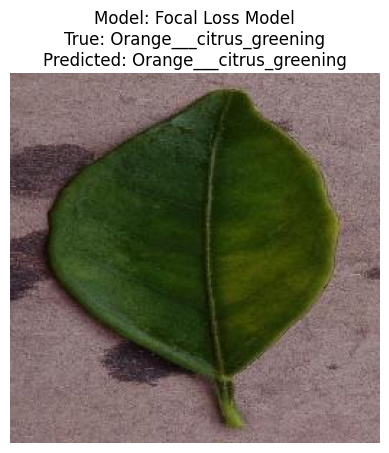

Model: Focal Loss Model
Image: 56748.jpg
True class: Orange___citrus_greening
Predicted class: Orange___citrus_greening
--------------------------------------------------


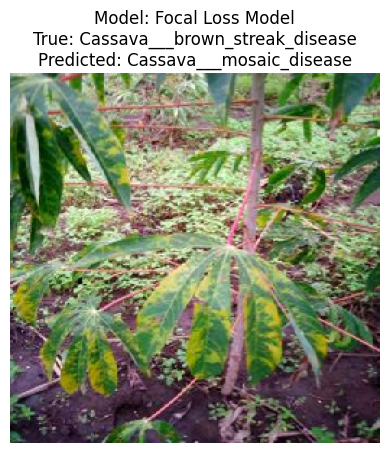

Model: Focal Loss Model
Image: 16476.jpg
True class: Cassava___brown_streak_disease
Predicted class: Cassava___mosaic_disease
--------------------------------------------------


In [39]:
random_image_predict(model_1_best, "Focal Loss Model", test_dir)

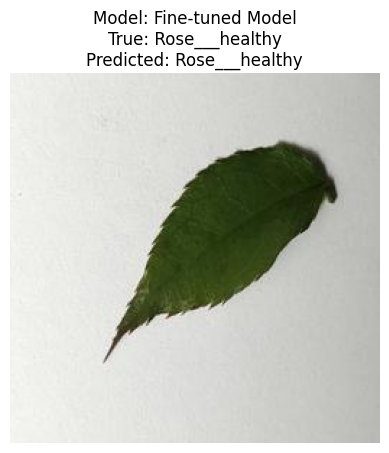

Model: Fine-tuned Model
Image: 3724.jpg
True class: Rose___healthy
Predicted class: Rose___healthy
--------------------------------------------------


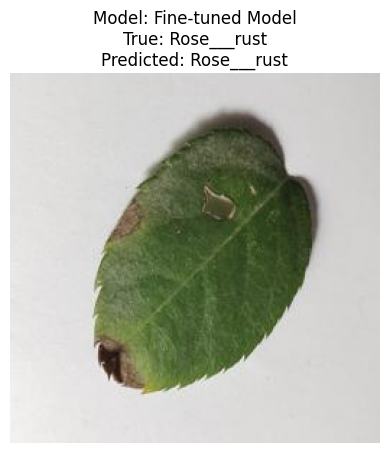

Model: Fine-tuned Model
Image: 7828.jpg
True class: Rose___rust
Predicted class: Rose___rust
--------------------------------------------------


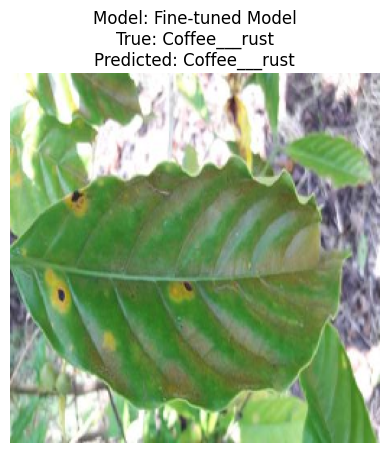

Model: Fine-tuned Model
Image: 103787.jpg
True class: Coffee___rust
Predicted class: Coffee___rust
--------------------------------------------------


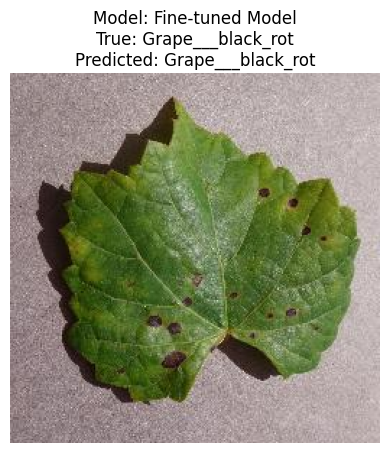

Model: Fine-tuned Model
Image: 52968.jpg
True class: Grape___black_rot
Predicted class: Grape___black_rot
--------------------------------------------------


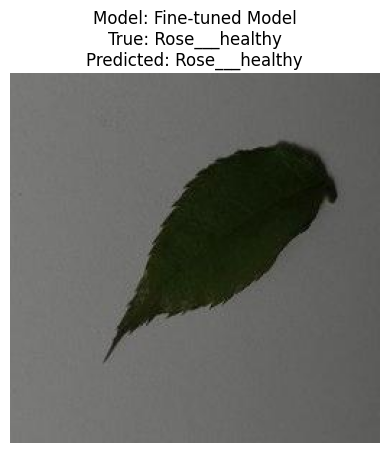

Model: Fine-tuned Model
Image: 824.jpg
True class: Rose___healthy
Predicted class: Rose___healthy
--------------------------------------------------


In [42]:
random_image_predict(model_2_best, "Fine-tuned Model", test_dir)